# Objectives

# Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, accuracy_score, precision_score


# Dataset

In [2]:
df = pd.read_csv('..\models\df_final.csv', low_memory=False)
display(df)

,Unnamed: 0,value_chart,valuenum_chartevent,chart_label,category,time_since_admission_chartevent,icd_code,admission_type,race,age,lab_results,lab_value_unit,priority,time_since_admission_labevent,death,BMI (kg/m2),Height (Inches),Weight (Lbs)
0,0,Full resistance,5.0,Strength L Arm,Neurological,13.116667,2724,SURGICAL SAME DAY ADMISSION,OTHER,66,138.0,mg/dL,Unknown,1.900000,0,0.0,71.00,0.00
1,1,1,1.0,20 Gauge Dressing Occlusive,Access Lines - Peripheral,4.183333,2724,EW EMER.,HISPANIC/LATINO - CUBAN,80,17.4,%,ROUTINE,4.200000,0,23.6,60.00,121.00
2,2,100,100.0,O2 saturation pulseoxymetry,Respiratory,5.316667,2724,ELECTIVE,WHITE,70,0.8,mg/dL,ROUTINE,20.000000,0,0.0,0.00,0.00
3,3,Some resistance,4.0,Strength L Leg,Neurological,8.500000,2724,EW EMER.,HISPANIC/LATINO - CUBAN,80,106.0,mEq/L,ROUTINE,4.200000,0,23.6,60.00,121.00
4,4,106,106.0,Non Invasive Blood Pressure mean,Routine Vital Signs,1.583333,2724,EW EMER.,WHITE,65,24.0,mEq/L,STAT,10.200000,0,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439545,465283,74,74.0,Non Invasive Blood Pressure mean,Routine Vital Signs,14.450000,Z87891,EW EMER.,WHITE,89,11.9,sec,ROUTINE,10.083333,0,26.0,66.00,161.16
439546,465284,-1 Awakens to voice (eye opening/contact) > 10...,-1.0,Richmond-RAS Scale,Pain/Sedation,16.516667,Z87891,OBSERVATION ADMIT,WHITE,58,15.1,K/uL,STAT,2.566667,0,25.8,67.63,165.00
439547,465285,22,22.0,Peak Insp. Pressure,Respiratory,9.516667,Z87891,OBSERVATION ADMIT,WHITE,58,31.7,sec,STAT,7.200000,0,25.8,67.63,165.00
439548,465286,74,74.0,Non Invasive Blood Pressure mean,Routine Vital Signs,4.766667,Z87891,OBSERVATION ADMIT,WHITE,58,12.9,g/dL,STAT,5.483333,0,25.8,67.63,165.00


In [3]:
# Contagem absoluta de cada código
print("Contagem absoluta de cada ICD code:")
print(df['icd_code'].value_counts())

# Contagem percentual (%)
print("\nDistribuição percentual de cada ICD code:")
print(df['icd_code'].value_counts(normalize=True) * 100)

Contagem absoluta de cada ICD code:
icd_code
2724      112268
4019      109263
Z87891     56766
E785       55047
Z794       53199
E039       53007
Name: count, dtype: int64

Distribuição percentual de cada ICD code:
icd_code
2724      25.541577
4019      24.857923
Z87891    12.914572
E785      12.523490
Z794      12.103060
E039      12.059379
Name: proportion, dtype: float64


# Treatment

In [3]:
df = df.copy()

In [4]:
class Treatment(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        df = X.copy()
        self.variables_cat = ['priority']
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.encoder.fit(df[self.variables_cat])
        self.ohe_columns = self.encoder.get_feature_names_out(self.variables_cat)

        self.label_encoders = {}
        variables_label = ['icd_code', 'category', 'race', 'lab_value_unit']
        
        for col in variables_label:
            if col in df.columns:
                le = LabelEncoder()
                le.fit(df[col].astype(str))
                self.label_encoders[col] = le

        return self

    def transform(self, X):
        df = X.copy()

        # Feature Interactions
        urgency_rank = {
            'Unknown': 0, 'ELECTIVE': 1, 'OBSERVATION ADMIT': 2,
            'SURGICAL SAME DAY ADMISSION': 3, 'URGENT': 4,
            'DIRECT EMER.': 5, 'EW EMER.': 6
        }
        
        if 'admission_type' in df.columns:
            df['urgency_score'] = df['admission_type'].map(urgency_rank)
            df['urgency_x_lab_delay'] = df['urgency_score'] * df['time_since_admission_labevent']
            df['admission_x_age'] = df['urgency_score'] * df['age']
            # Drop da variável original
            df.drop(columns=['admission_type'], inplace=True)

        # OneHotEncoding
        one_hot_encoded = self.encoder.transform(df[self.variables_cat])
        one_hot_df = pd.DataFrame(one_hot_encoded, columns=self.ohe_columns, index=df.index)
        df = pd.concat([df.drop(columns=self.variables_cat), one_hot_df], axis=1)

        # LabelEncoding 
        for col, le in self.label_encoders.items():
            if col in df.columns:
                df[col] = le.transform(df[col].astype(str))
            else:
                print(f"Aviso: Coluna '{col}' não encontrada em transform().")

        # Frequency encoding
        if 'value_chart' in df.columns:
            df['value_chart'] = df['value_chart'].astype(str)
            df['value_chart_freq'] = df['value_chart'].map(df['value_chart'].value_counts())
            df.drop(columns=['value_chart'], inplace=True)

        if 'chart_label' in df.columns:
            df['chart_label'] = df['chart_label'].astype(str)
            df['chart_label_freq'] = df['chart_label'].map(df['chart_label'].value_counts())
            df.drop(columns=['chart_label'], inplace=True)

        return df


# Model

In [5]:

le = LabelEncoder()
y = le.fit_transform(df['icd_code'])
X = df.drop('icd_code', axis=1)

In [6]:
print(le.classes_)
joblib.dump(le, 'label_encoder_icd.pkl')

['2724' '4019' 'E039' 'E785' 'Z794' 'Z87891']


['label_encoder_icd.pkl']

In [7]:
treatment = Treatment()
X_processed = treatment.fit_transform(X)
joblib.dump(treatment, 'treatment.pkl')

['treatment.pkl']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify=y, test_size=0.33, random_state=42)

In [9]:

param_dist = {
    'model__max_depth': [6,8],
    'model__learning_rate': [0.05, 0.1],
    'model__gamma': [0, 0.5],
    'model__min_child_weight': [1, 3],
    'model__reg_alpha': [0, 0.1],
    'model__reg_lambda': [1, 2],
    'model__n_estimators': [100, 150]  
}


pipeline = Pipeline([
    ('model', xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=len(le.classes_),
        tree_method='hist',
        eval_metric='mlogloss',
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        random_state=42
    ))
])

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_dist,
    scoring='precision_weighted',
    cv=3,
    n_jobs=-1,
    verbose=2 )

In [10]:

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:54:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.8,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None, num_class=6, ...))]),
             n_jobs=-1,
             param_grid={'model__gamma': [0, 0.5],
                         'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [6, 8],
                         'model__min_child_weight': [1, 3],
                         'model__n_estimators': [100, 150],
                         'model__reg_alpha': [0, 0.1],
                         'model__reg_lambda': [1, 2]},
             scoring='precision_weighted', verbose=2)

In [11]:

y_pred = grid_search.predict(X_test)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# mean CV = 5
print("Accuracy - Internal validation:", grid_search.best_score_)

print("\nAccuracy - Real", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 99.95%
Accuracy - Internal validation: 0.999334972248708

Accuracy - Real 0.999462261809558
Precision (macro): 0.999556598001402

Classification Report:
               precision    recall  f1-score   support

        2724       1.00      1.00      1.00     37048
        4019       1.00      1.00      1.00     36057
        E039       1.00      1.00      1.00     17492
        E785       1.00      1.00      1.00     18166
        Z794       1.00      1.00      1.00     17556
      Z87891       1.00      1.00      1.00     18733

    accuracy                           1.00    145052
   macro avg       1.00      1.00      1.00    145052
weighted avg       1.00      1.00      1.00    145052



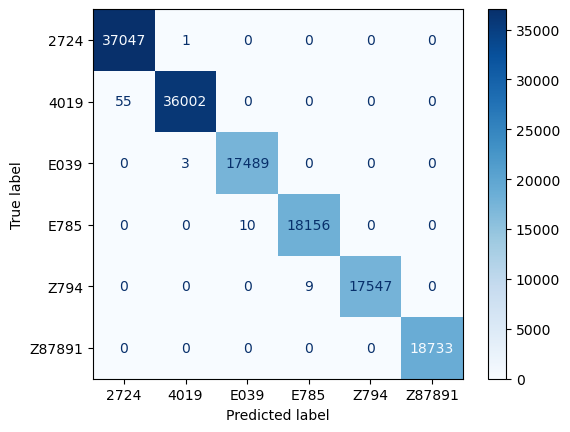

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cria a matriz de confusão
# Supondo que tens:
# y_test -> rótulos reais
# y_pred -> predições do modelo
# classes -> lista das classes (ex.: [0,1,2,3,4,5] ou códigos ICD)

cm = confusion_matrix(y_test, y_pred)

# Exibir a matriz de confusão de forma visual
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues') 

In [13]:

joblib.dump(grid_search.best_estimator_, 'modelo_pipeline_final.pkl')

['modelo_pipeline_final.pkl']

# Overfit

In [14]:
from sklearn.metrics import accuracy_score, f1_score

y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print("Accuracy treino:", accuracy_score(y_train, y_train_pred))
print("Accuracy teste:", accuracy_score(y_test, y_test_pred))
print("F1 treino:", f1_score(y_train, y_train_pred, average='macro'))
print("F1 teste:", f1_score(y_test, y_test_pred, average='macro'))

Accuracy treino: 0.9996638347289285
Accuracy teste: 0.999462261809558
F1 treino: 0.9997329328772689
F1 teste: 0.9995458607058444


In [16]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(grid_search.best_estimator_, X, y, cv=cv, scoring='f1_weighted')

print("CV mean F1:", np.mean(scores))
print("CV std:", np.std(scores))

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py", line 407, in pandas_feature_info
    new_feature_types.append(_pandas_dtype_mapper[dtype.name])
                             ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'object'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\catar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\catar\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py", line 1663, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py", line 628, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py", line 1137, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py", line 1614, in __init__
    self._init(
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py", line 1678, in _init
    it.reraise()
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py", line 572, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py", line 553, in _handle_exception
    return fn()
           ^^^^
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py", line 640, in <lambda>
    return self._handle_exception(lambda: int(self.next(input_data)), 0)
                                              ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py", line 1654, in next
    input_data(**self.kwargs)
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py", line 620, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
                                                   ^^^^^^^^^^^^^^^^^
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py", line 1707, in _proxy_transform
    df, feature_names, feature_types = _transform_pandas_df(
                                       ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py", line 640, in _transform_pandas_df
    feature_names, feature_types = pandas_feature_info(
                                   ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py", line 409, in pandas_feature_info
    _invalid_dataframe_dtype(data)
  File "C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py", line 372, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:value_chart: object, chart_label: object, category: object, admission_type: object, race: object, lab_value_unit: object, priority: object


# Example

## Download 

In [14]:
treatment = joblib.load('treatment.pkl')
pipeline = joblib.load('modelo_pipeline_final.pkl')
le = joblib.load('label_encoder_icd.pkl')

In [48]:
cases = pd.read_csv('..\models\cases.csv')

In [49]:
case = treatment.transform(cases)

expected_cols = pipeline.named_steps['model'].feature_names_in_
missing_cols = set(expected_cols) - set(case.columns)

print("Missing columns:")
print(missing_cols)


Aviso: Coluna 'lab_value_unit' não encontrada em transform().


KeyError: 'value_chart'

In [ ]:
display(cases)

,subject_id,value_chartevent,valuenum_chartevent,valueuom_chartevent,label_chartevent,category,time_since_admission_chartevent,admission_type,insurance,race,admission_location,age,value_labevent,valuenum_labevent,valueuom_labevent,priority,time_since_admission_labevent
0,1,No movement,36.8,Unknown,Temperature Celsius,Routine Vital Signs,12.00,URGENT,Medicare,WHITE,EMERGENCY ROOM,72,2.0,2.0,mg/dL,STAT,1.20
1,2,27,27.0,mA,Temporary Ventricular Stim Setting mA,Cardiovascular (Pacer Data),2.50,EW EMER.,Other,HISPANIC OR LATINO,PHYSICIAN REFERRAL,67,333.0,333.0,mm Hg,Unknown,2.00
2,3,8,8.0,insp/min,Resp Alarm - Low,Alarms,12.55,EW EMER.,Other,WHITE,PHYSICIAN REFERRAL,59,8.9,8.9,g/dL,STAT,14.95


In [20]:
preds = pipeline.predict(case)
print(preds)

[1 1 4]


In [21]:
lable = pd.read_csv('..\models\icd_match.csv')

In [22]:
icd_dict = dict(zip(lable['icd_code'], lable['long_title']))

In [24]:

predicted_icd_codes = le.inverse_transform(preds)
for i, (index, row) in enumerate(cases.iterrows()):
    icd_code = predicted_icd_codes[i]
    description = icd_dict.get(icd_code)
    
    print(f"Example {i+1}:")
    print(row.to_dict())  
    print(f"Result: {icd_code} - {description}")
    print("-" * 40)




Example 1:
{'subject_id': 1, 'value_chartevent': 'No movement', 'valuenum_chartevent': 36.8, 'valueuom_chartevent': 'Unknown', 'label_chartevent': 'Temperature Celsius', 'category': 'Routine Vital Signs', 'time_since_admission_chartevent': 12.0, 'admission_type': 'URGENT', 'insurance': 'Medicare', 'race': 'WHITE', 'admission_location': 'EMERGENCY ROOM', 'age': 72, 'value_labevent': 2.0, 'valuenum_labevent': 2.0, 'valueuom_labevent': 'mg/dL', 'priority': 'STAT', 'time_since_admission_labevent': 1.2}
Result: 4019 - Unspecified essential hypertension
----------------------------------------
Example 2:
{'subject_id': 2, 'value_chartevent': '27', 'valuenum_chartevent': 27.0, 'valueuom_chartevent': 'mA', 'label_chartevent': 'Temporary Ventricular Stim Setting mA', 'category': 'Cardiovascular (Pacer Data)', 'time_since_admission_chartevent': 2.5, 'admission_type': 'EW EMER.', 'insurance': 'Other', 'race': 'HISPANIC OR LATINO', 'admission_location': 'PHYSICIAN REFERRAL', 'age': 67, 'value_labe